# Machine Learning Project: 2D to 3D Image Rendering  
### Hossein Mohammadi, Chau Nguyen, Paul Nguyen


We are using a hybrid model which uses depth estimation(midas) and neural implicit representations (NeRf) for a better 3d reconstruction

1)Define the Hybrid Model Approach
Your hybrid model will likely combine:

a)Depth Estimation (MiDaS or DPT) – Extracts depth information from a single image.

b)Multi-View Synthesis (NeRF) – Uses depth cues and multiple views to generate a high-quality 3D model.

c)Mesh Generation (Poisson Reconstruction or Marching Cubes) – Converts depth maps and NeRF outputs into a structured 3D object.

Libraries: torch, pytorch3d, matplotlib, numpy, cv2, scikit-image, open3D


In [ ]:
!pip install torch 
!pip install numpy 
!pip install matplotlib 
!pip install scikit-image 
!pip install open3d 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install torch torchvision torchaudio
!pip install opencv-python numpy matplotlib timm

# Creating a depth map using MiDaS or MiDaS_small depending on the accuracy that is wanted


Loading MiDaS model...


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Loading weights:  None


Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth
100%|██████████| 340M/340M [00:14<00:00, 24.7MB/s]
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_384.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_384.pt
100%|██████████| 403M/403M [00:23<00:00, 17.9MB/s]


Model loaded successfully!


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Original tensor shape: torch.Size([1, 3, 288, 384])
Final input shape: torch.Size([1, 3, 288, 384])
Running depth estimation...


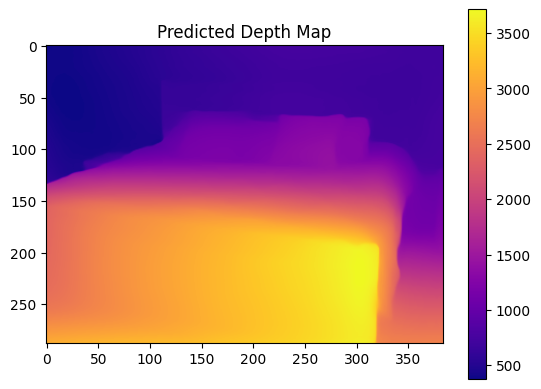

Depth estimation complete!


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load MiDaS model from PyTorch Hub
print("Loading MiDaS model...")

#MiDaS_large model
model = torch.hub.load("intel-isl/MiDaS", "MiDaS")
model.eval()
print("Model loaded successfully!")

# Make sure to use the correct file path
image_path = "./0003.png"  # Change if necessary

# Verify image exists
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}. Please check the file path.")

# Convert image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load MiDaS transformations
transform = torch.hub.load("intel-isl/MiDaS", "transforms").default_transform
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension If the shape is [1, 1, H, W]

image_tensor = image_tensor.squeeze(1)  # Remove extra dimension If the shape is something like [1, 1, 1, H, W]

print(f"Original tensor shape: {image_tensor.shape}")

# Fix shape issue: Ensure it's [1, 3, H, W]
if image_tensor.shape[1] == 1:
    image_tensor = image_tensor.repeat(1, 3, 1, 1)  # Convert grayscale to 3-channel RGB
elif image_tensor.shape[1] > 3:
    image_tensor = image_tensor[:, :3, :, :]  # Drop extra channels

# Print tensor shape for debugging
print(f"Final input shape: {image_tensor.shape}")  # Should be [1, 3, H, W]

# Predict depth
print("Running depth estimation...")
with torch.no_grad():
    depth_map = model(image_tensor)

# Show depth output
plt.imshow(depth_map.squeeze(), cmap='plasma')
plt.colorbar()
plt.title("Predicted Depth Map")
plt.show()
print("Depth estimation complete!")


# Convert MiDaS depth map to 3d coordinates

In [4]:
!pip install open3d

In [5]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

def depth_to_point_cloud(depth_map, intrinsic_matrix, scale=1.0):
    """Convert depth map to a 3D point cloud using camera intrinsics."""
    h, w = depth_map.shape
    fx, fy, cx, cy = intrinsic_matrix
    points = []


    for i in range(h):
        for j in range(w):
            z = depth_map[i, j] * scale  # Depth value
            if z > 0:  # Ignore zero-depth pixels
                x = (j - cx) * z / fx
                y = (i - cy) * z / fy
                points.append([x, y, z])

    return np.array(points)

# Example intrinsic parameters (adjust as needed)
intrinsic_matrix = [500, 500, 320, 240]  # fx, fy, cx, cy
depth_numpy = depth_map.squeeze().cpu().numpy()
point_cloud = depth_to_point_cloud(depth_numpy, intrinsic_matrix)

# Convert to Open3D format & save
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
o3d.io.write_point_cloud("point_cloud.ply", pcd)


True

# convert 3d coordinates to 3d mesh


In [6]:
import open3d as o3d

# Load the saved point cloud
pcd = o3d.io.read_point_cloud("point_cloud.ply")

# Estimate normals for meshing
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Option 1: Poisson surface reconstruction (Best for smooth surfaces)
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)

# Option 2: Ball Pivoting Algorithm (BPA) (Better for sparse/noisy data)
radii = [0.005, 0.01, 0.02, 0.04]
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))

# Save meshes
o3d.io.write_triangle_mesh("poisson_mesh.ply", mesh)
o3d.io.write_triangle_mesh("bpa_mesh.ply", bpa_mesh)

# Visualize Mesh (headless, Matplotlib alternative)
o3d.visualization.draw_geometries([mesh])


[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


# Improved MiDaS model for a more clear image ~ Includes heat map generation and mesh


Loading MiDaS model...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:36<00:00, 37.7MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Model and transforms loaded!


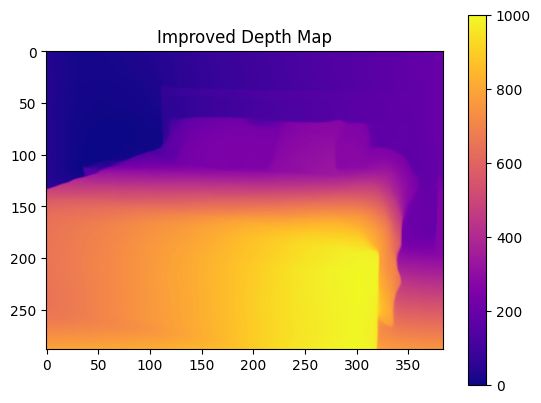

[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Running Poisson mesh reconstruction...
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# Step 1: Load MiDaS model
print("Loading MiDaS model...")
# CHANGE -- DPT-Large architecture
model_type = "DPT_Large"  # options: DPT_Large, DPT_Hybrid, MiDaS_small
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()

# Use the correct transform for this DPT model
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if model_type.startswith("DPT") else midas_transforms.small_transform
print("Model and transforms loaded!")

# Step 2: Load and prepare image
image_path = "./0003.png"  # Update path
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = transform(img_rgb)
if input_tensor.ndim == 3:
    input_tensor = input_tensor.unsqueeze(0)  # Ensure shape [1, 3, H, W]

# Step 3: Predict depth
with torch.no_grad():
    prediction = midas(input_tensor)
depth_map = prediction.squeeze().cpu().numpy()

# CHANGE -- Step 4: Normalize and scale depth for consistency
depth_min = depth_map.min()
depth_max = depth_map.max()
depth_norm = (depth_map - depth_min) / (depth_max - depth_min)
depth_scaled = depth_norm * 1000  # Scale to mm or cm

# Visualize depth map
plt.imshow(depth_scaled, cmap='plasma')
plt.title("Improved Depth Map")
plt.colorbar()
plt.show()

# CHANGE -- Step 5: Generate dynamic camera intrinsics
h, w = depth_scaled.shape
fx = fy = 0.8 * w
cx = w / 2
cy = h / 2
intrinsic_matrix = [fx, fy, cx, cy]

# Step 6: Convert depth to 3D point cloud
def depth_to_point_cloud(depth, intrinsics):
    fx, fy, cx, cy = intrinsics
    h, w = depth.shape
    points = []
    for i in range(h):
        for j in range(w):
            z = depth[i, j]
            if z > 0:
                x = (j - cx) * z / fx
                y = (i - cy) * z / fy
                points.append([x, y, z])
    return np.array(points)

points = depth_to_point_cloud(depth_scaled, intrinsic_matrix)

# Step 7: Create and clean point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
# CHANGE -- Voxel Downsampling
pcd = pcd.voxel_down_sample(voxel_size=5.0)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=30.0, max_nn=30))

# Visualize point cloud
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")

# Step 8: Mesh reconstruction
print("Running Poisson mesh reconstruction...")
mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)
mesh.compute_vertex_normals()

# Save and visualize mesh
o3d.io.write_triangle_mesh("reconstructed_mesh.ply", mesh)
o3d.visualization.draw_geometries([mesh], window_name="Mesh")



# Neural rendering with NeRF



In [8]:
!git clone https://github.com/yenchenlin/nerf-pytorch.git
%cd nerf-pytorch

Cloning into 'nerf-pytorch'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 461 (delta 0), reused 0 (delta 0), pack-reused 459 (from 2)
Receiving objects: 100% (461/461), 3.99 MiB | 10.85 MiB/s, done.
Resolving deltas: 100% (263/263), done.
/content/nerf-pytorch


In [9]:
!pip install imageio imageio-ffmpeg matplotlib tqdm
!pip install torch torchvision


In [10]:
!ls
!pip install configargparse


configs			  load_blender.py     README.md
download_example_data.sh  load_deepvoxels.py  requirements.txt
imgs			  load_LINEMOD.py     run_nerf_helpers.py
LICENSE			  load_llff.py	      run_nerf.py


# connect to GPU if its available


In [11]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

PyTorch version: 2.6.0+cu124
CUDA available: False
GPU name: N/A


# preparing dataset for NeRF


In [ ]:
import json
import os

# Path to Pix3D metadata
with open("./pix3d/pix3d.json", "r") as f:
    pix3d_metadata = json.load(f)

# Example of one entry
print(pix3d_metadata[0])


{'img': 'img/bed/0001.png', 'category': 'bed', 'img_size': [395, 244], '2d_keypoints': [[[182.5, 147.09375], [174.5, 225.09375], [16.5, 111.09375], [-1.0, -1.0], [-1.0, -1.0], [324.5, 101.09375], [336.5, 51.09375], [226.5, 20.09375], [-1.0, -1.0], [352.5, 121.09375]], [[181.5, 165.09375], [181.5, 224.09375], [3.5, 112.09375], [5.5, 141.09375], [-1.0, -1.0], [352.5, 90.09375], [349.5, 34.09375], [196.5, 26.09375], [-1.0, -1.0], [346.5, 114.09375]], [[171.5, 139.09375], [175.5, 227.09375], [29.5, 90.09375], [-1.0, -1.0], [-1.0, -1.0], [340.5, 80.09375], [351.5, 32.09375], [198.5, 22.09375], [-1.0, -1.0], [268.5, 79.09375]]], 'mask': 'mask/bed/0001.png', 'img_source': 'ikea', 'model': 'model/bed/IKEA_MALM_2/model.obj', 'model_raw': None, 'model_source': 'ikea', '3d_keypoints': 'model/bed/IKEA_MALM_2/3d_keypoints.txt', 'voxel': 'model/bed/IKEA_MALM_2/voxel.mat', 'rot_mat': [[0.7813941591465821, 0.00095539348511137, -0.6240370624208909], [0.17456672296585038, 0.9597407704535225, 0.220054794

Convert Pix3D Metadata into NeRF transforms.json


In [ ]:
import os
import json
import math
import numpy as np

def create_transforms_from_pix3d_fixed(pix3d_json_path, image_folder, output_json_path, sensor_width_mm=36.0):
    with open(pix3d_json_path, "r") as f:
        pix3d_data = json.load(f)

    frames = []
    first_valid = True
    for entry in pix3d_data:
        img_path = os.path.join(image_folder, os.path.basename(entry['img']))
        if not os.path.exists(img_path):
            continue  # Skip missing images

        focal_mm = entry['focal_length']
        img_width, img_height = entry['img_size']

        fx = (focal_mm / sensor_width_mm) * img_width
        fy = (focal_mm / sensor_width_mm) * img_width  # Assume square pixels for simplicity
        cx = img_width / 2
        cy = img_height / 2

        # Build 4x4 extrinsic matrix
        rot = np.array(entry['rot_mat'])
        trans = np.array(entry['trans_mat']).reshape(3, 1)
        extrinsic = np.hstack((rot, trans))
        extrinsic = np.vstack((extrinsic, [0, 0, 0, 1]))
        extrinsic = extrinsic.tolist()

        if first_valid:
            fl_x = fx
            fl_y = fy
            c_x = cx
            c_y = cy
            w = img_width
            h = img_height
            first_valid = False

        frames.append({
            "file_path": f"./{os.path.basename(entry['img'])}",
            "transform_matrix": extrinsic
        })

    transforms = {
        "fl_x": fl_x,
        "fl_y": fl_y,
        "cx": c_x,
        "cy": c_y,
        "w": w,
        "h": h,
        "camera_angle_x": 2 * math.atan(w / (2 * fl_x)),
        "frames": frames
    }

    with open(output_json_path, 'w') as f:
        json.dump(transforms, f, indent=4)

# Example usage:
# 1. Create the target folder
os.makedirs("./your_data", exist_ok=True)

# 2. Then run the converter script
create_transforms_from_pix3d_fixed(
    pix3d_json_path="./pix3d/pix3d.json",
    image_folder="./pix3d/img/bed/",
    output_json_path="./your_data/transforms.json"
)


copy images to "your_data" folder


In [ ]:
import shutil
import os
import json

# Paths
pix3d_json_path = "./pix3d/pix3d.json"
original_images_folder = "./pix3d/img/bed/"
output_folder = "./your_data/"

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load Pix3D metadata
with open(pix3d_json_path, "r") as f:
    pix3d_data = json.load(f)

# Copy matching images
count = 0
for entry in pix3d_data:
    if entry['category'] != 'bed':
        continue

    img_name = os.path.basename(entry['img'])
    src_path = os.path.join(original_images_folder, img_name)
    dst_path = os.path.join(output_folder, img_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        count += 1



In [17]:
config_text = """
basedir = ./logs
expname = pix3d_test

dataset_type = blender
datadir = ./your_data
half_res = True
white_bkgd = True
N_rand = 512
lrate = 5e-4
lrate_decay = 250
chunk = 1024
netchunk = 1024
i_print = 100
i_img = 1000
i_weights = 1000
i_testset = 1000
i_video = 1000
N_samples = 32
N_importance = 32
raw_noise_std = 0.0
render_factor = 4
factor = 2
"""


with open("custom_pix3d.txt", "w") as f:
    f.write(config_text)

print("Updated custom_pix3d.txt")


Updated custom_pix3d.txt


In [ ]:
import shutil

# Copy your transforms.json to train and test versions
shutil.copy("./your_data/transforms.json", "./your_data/transforms_train.json")
shutil.copy("./your_data/transforms.json", "./your_data/transforms_test.json")

print("Copied transforms.json to transforms_train.json and transforms_test.json")


Copied transforms.json to transforms_train.json and transforms_test.json


In [ ]:
import os
import json
import random

# Load your original transforms.json
with open("./your_data/transforms.json", "r") as f:
    original = json.load(f)

frames = original['frames']
print(f"Found {len(frames)} total frames.")

# Shuffle the frames randomly
random.shuffle(frames)

# 80% train, 10% test, 10% val
n_total = len(frames)
n_train = int(0.8 * n_total)
n_test = int(0.1 * n_total)
n_val = n_total - n_train - n_test

train_frames = frames[:n_train]
test_frames = frames[n_train:n_train+n_test]
val_frames = frames[n_train+n_test:]

# Helper function to save new split JSONs
def save_split(frames_split, filename):
    split_data = {
        "fl_x": original["fl_x"],
        "fl_y": original["fl_y"],
        "cx": original["cx"],
        "cy": original["cy"],
        "w": original["w"],
        "h": original["h"],
        "camera_angle_x": original["camera_angle_x"],
        "frames": frames_split
    }
    with open(f"/content/your_data/{filename}", "w") as f:
        json.dump(split_data, f, indent=4)

# Save the splits
save_split(train_frames, "transforms_train.json")
save_split(test_frames, "transforms_test.json")
save_split(val_frames, "transforms_val.json")

print(f"Saved {len(train_frames)} train frames, {len(test_frames)} test frames, and {len(val_frames)} val frames.")


Found 4746 total frames.
Saved 3796 train frames, 474 test frames, and 476 val frames.


In [ ]:
!mv /content/your_data /content/nerf-pytorch/your_data



In [21]:
%cd /content/nerf-pytorch


/content/nerf-pytorch


In [ ]:
import os
import json

image_folder = "./nerf-pytorch/your_data"

def fix_json_to_exact_disk_files(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    fixed_count = 0

    for frame in data["frames"]:
        base_name = os.path.basename(frame["file_path"]).split('.')[0]  # base name without extension

        # Look on disk for the actual file
        found = False
        for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
            candidate = os.path.join(image_folder, base_name + ext)
            if os.path.isfile(candidate):
                frame["file_path"] = f"./{base_name}{ext}"  # use exact extension
                fixed_count += 1
                found = True
                break

        if not found:
            print(f"WARNING: No matching file found for {base_name}")

    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

    print(f"Corrected {fixed_count} entries in {json_path}")

# Apply to all three JSON files
fix_json_to_exact_disk_files(os.path.join(image_folder, "transforms_train.json"))
fix_json_to_exact_disk_files(os.path.join(image_folder, "transforms_test.json"))
fix_json_to_exact_disk_files(os.path.join(image_folder, "transforms_val.json"))



Corrected 3796 entries in /content/nerf-pytorch/your_data/transforms_train.json
Corrected 474 entries in /content/nerf-pytorch/your_data/transforms_test.json
Corrected 476 entries in /content/nerf-pytorch/your_data/transforms_val.json


# Running the extracted dataset from Pix3d into NeRF

In [ ]:
!python run_nerf.py --config custom_pix3d.txt


/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
^C


**Credits**:
@misc{lin2020nerfpytorch,
  title={NeRF-pytorch},
  author={Yen-Chen, Lin},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished={\url{https://github.com/yenchenlin/nerf-pytorch/}},
  year={2020}
}